# Aula 10 - MultiDoc Q&A

[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


# Enunciado exercício


Implementar um pipeline multidoc QA: 

dado uma pergunta do usuário, buscamos em uma grande coleção as passagens mais relevantes e as enviamos para um sistema agregador, que irá gerar uma resposta final.
Avaliar no dataset do IIRC
Métrica principal: F1
Limitar dataset de teste para 50 exemplos para economizar.
Usar o gpt-3.5-turbo como modelo agregador. Usar vicuna-13B como alternativa open-source:
https://huggingface.co/helloollel/vicuna-13b 
https://chat.lmsys.org/ 
Dicas:
Se inspirar no pipeline do Visconde: https://github.com/neuralmind-ai/visconde 



Fonte: foi usado como apoio e base de "inspiração" o código relativo ao teste com o dataset IIRC em https://github.com/neuralmind-ai/visconde



Parte 2: usa api para responder e avaliar as métricas para os prompts gerados em caderno anterior

# Organizando o ambiente

## Importações

In [54]:
import re

In [2]:
from tqdm import tqdm

In [3]:
import os
import openai

from transformers import GPT2Tokenizer

/home/borela/miniconda3/envs/treinapython39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import copy

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import getpass

In [6]:
import gc

In [12]:
import pandas as pd
import os

In [13]:
import numpy as np


In [ ]:
from collections import Counter
from tqdm import tqdm


In [14]:
import pickle

In [15]:
from statistics import mean, stdev

In [ ]:
from tqdm import tqdm
import json
import re


100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat

In [ ]:
import json
import argparse
import collections
import numpy as np
import os
import re
import string
import sys
import unicodedata


## Definindo paths

In [16]:
DIRETORIO_LOCAL = '/home/borela/fontes/deep_learning_em_buscas_unicamp/local'
DIRETORIO_TRABALHO = F'{DIRETORIO_LOCAL}/multidocqa'


In [17]:
if os.path.exists(DIRETORIO_TRABALHO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TRABALHO)
    print('pasta criada!')


pasta já existia!


## Preparando para debug e display

In [18]:
def config_display():
  """
  Esta função configura as opções de display do Pandas.
  """

  # Configurando formato saída Pandas
  # define o número máximo de colunas que serão exibidas
  pd.options.display.max_columns = None

  # define a largura máxima de uma linha
  pd.options.display.width = 1000

  # define o número máximo de linhas que serão exibidas
  pd.options.display.max_rows = 100

  # define o número máximo de caracteres por coluna
  pd.options.display.max_colwidth = 50

  # se deve exibir o número de linhas e colunas de um DataFrame.
  pd.options.display.show_dimensions = True

  # número de dígitos após a vírgula decimal a serem exibidos para floats.
  pd.options.display.precision = 7


In [19]:
config_display()

# Base code

In [26]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [27]:
os.environ['OPENAI_API_KEY'] = getpass.getpass('Informe OPENAI_API_KEY')

In [28]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [38]:
os.environ['OPENAI_CA_BUNDLE'] = ''

model text-davinci-003 (gpt 3.5)
Can do any language task with better quality, longer output, and consistent instruction-following than the curie, babbage, or ada models. Also supports inserting completions within text.

model text-davinci-002 (gpt 3.5)
Similar capabilities to text-davinci-003 but trained with supervised fine-tuning instead of reinforcement learning



In [43]:
def generate(prompt,max_tokens=256, temperature=0):
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=prompt,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    return response["choices"][0]['text']

In [ ]:

def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  def remove_accents(input_str):
      nfkd_form = unicodedata.normalize('NFKD', input_str)
      only_ascii = nfkd_form.encode('ASCII', 'ignore')
      return only_ascii.decode("utf-8")

  return white_space_fix(remove_articles(remove_punc(lower(remove_accents(s)))))


In [ ]:
def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))


In [134]:
def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  dif_words = list(set(gold_toks) - set(pred_toks))
  if dif_words == ['years']:
      return 1
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1


In [ ]:
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  def remove_accents(input_str):
      nfkd_form = unicodedata.normalize('NFKD', input_str)
      only_ascii = nfkd_form.encode('ASCII', 'ignore')
      return only_ascii.decode("utf-8")

  return white_space_fix(remove_articles(remove_punc(lower(remove_accents(s)))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()


In [145]:

def compute_exact(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  dif_words = list(set(gold_toks) - set(pred_toks))
  if dif_words == ['years']:
      return 1
  else:
      return int(normalize_answer(a_gold) == normalize_answer(a_pred))




# Answer generation with ground truth prompts

Load prompt list

In [94]:
with open(f"{DIRETORIO_TRABALHO}/list_prompt_answer_ground_truth.pkl", 'rb') as outputFile:
    list_prompt_answer = pickle.load(outputFile)

In [171]:
list_prompt_answer[0]['prompt'][:200]

'Follow examples bellow and generate value for Evidence and value for Answer. For each example, use the documents to provide an answer to the question and cite evidence from the documents to support th'

Generate

In [ ]:
%%time
temperature = 0
attempts = 1
pattern = "(?<=Answer:)(.*)$"

for item in tqdm(list_prompt_answer):
    item['responses'] = []
    item['results'] = ''
    item['completions'] = []
    item["asked_twice"] = None
    for i in range(attempts):
        res = generate(item['prompt'],temperature=temperature)
        if "Answer" not in res:
            item["new_prompt"] = "{0}{1}\n\nAnswer:".format(item["prompt"], res)
            res2= generate(item["new_prompt"])
            item['results'] = "{0}\n\nAnswer: {1}".format(res, res2)
            item['responses'].append(res2)
            item['completions'].append("{0}\n\nAnswer: {1}".format(res, res2))
            item["asked_twice"] = True
        else:
            matches = re.findall(pattern, res)
            if len(matches) > 0: 
                response = matches[0]
                item['responses'].append(response)
            item['results'] = res 
            item['completions'].append(res)
            item["asked_twice"] = False       
# json.dump(test, open("results/iirc.json",'w'))

In [97]:
json.dump(list_prompt_answer, open(f"{DIRETORIO_TRABALHO}/list_prompt_answer_ground_truth_with_resp.json",'w'))

In [98]:
list_prompt_answer_ground_truth =  copy.deepcopy(list_prompt_answer)

In [99]:
list_prompt_answer[0]

{'prompt': 'Follow examples bellow and generate value for Evidence and value for Answer. For each example, use the documents to provide an answer to the question and cite evidence from the documents to support the answer. All questions have an answer, and just one answer. Please complete with valid format. It must have 2 fields Evidence and Answer. If the answer is a value, complete with just one word for the unit used. Example: prefer "5 years" than just 5 or "5 years old".\n\nExample 1:\n\nDocument 1: Title: Fred J. Shields. Content: Ollie Murphy\'s first-half goal gave \'the Royals\' a huge boost at half-time.\n\nDocument 2: Title: Ollie Murphy. Content: He plays club football for Carnaross\n\nDocument 3: Title: Ollie Murphy. Content: He came to national prominence in 1999 when he was one of Meath\'s best player\'s\n\nDocument 4: Title: The Thrilling World. Content: Sports encompass a wide range of physical activities that bring joy, competition, and excitement to millions of people

Evaluate

In [ ]:
from collections import Counter
from tqdm import tqdm


In [155]:

f1s = []
ems = []
lista_resposta_llm = []
lista_type_answer = []

for item in tqdm(list_prompt_answer):
    response =  normalize_answer(item['results'].split("Answer:")[1].strip().replace('\n',''))
    #try:
    #    c = Counter(normalised)
    #    response = c.most_common(1)[0][0]  #c.most_common(1) pode ser, por exemplo, [('no', 1)]
    #except:
    #    response=''
    f1 = compute_f1(item['answer'], response)
    f1s.append(f1)
    ems.append(compute_exact(item['answer'], response))
    if item['answer'] in ['yes', 'no']:
       type_answer = 'binary'
    else:
       type_answer = 'value'
    lista_type_answer.append(type_answer)    
    lista_resposta_llm.append(response)

print("F1:",np.mean(f1s))
print("EM:",np.mean(ems))

100%|██████████| 20/20 [00:00<00:00, 5562.74it/s]

F1: 0.7185714285714286
EM: 0.65


In [156]:
df_gt = pd.DataFrame(list_prompt_answer)

In [157]:
df_gt['f1'] = f1s

In [158]:
df_gt['em'] = ems

In [159]:
df_gt['answer_llm'] = lista_resposta_llm

In [160]:
df_gt['type_answer'] = lista_type_answer

In [161]:
df_gt

,prompt,answer,responses,results,completions,asked_twice,new_prompt,f1,em,answer_llm,type_answer
0,Follow examples bellow and generate value for ...,no,[ no],"Based on the information in Document 1, it is...","[ Based on the information in Document 1, it i...",False,NaN,1.0000000,1,no,binary
1,Follow examples bellow and generate value for ...,yes,[ Unknown],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",False,NaN,0.0000000,0,unknown,binary
2,Follow examples bellow and generate value for ...,yes,[ Unknown],The document does not provide enough informat...,[ The document does not provide enough informa...,True,Follow examples bellow and generate value for ...,0.0000000,0,unknown,binary
3,Follow examples bellow and generate value for ...,no,[],Document 1 says that German Type IXD2 submari...,[ Document 1 says that German Type IXD2 submar...,False,NaN,0.0000000,0,yes,binary
4,Follow examples bellow and generate value for ...,no,[],"\n\nDocument 1 says that Denne Weigall, an arm...","[\n\nDocument 1 says that Denne Weigall, an ar...",False,NaN,1.0000000,1,no,binary
5,Follow examples bellow and generate value for ...,no,[ No],"Based on the information in Document 1, it ca...","[ Based on the information in Document 1, it c...",False,NaN,1.0000000,1,no,binary
6,Follow examples bellow and generate value for ...,yes,[ Yes],"Yes, the starting USC quarterback Sanchez rep...","[ Yes, the starting USC quarterback Sanchez re...",True,Follow examples bellow and generate value for ...,1.0000000,1,yes,binary
7,Follow examples bellow and generate value for ...,yes,[\n\nYes],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0000000,1,yes,binary
8,Follow examples bellow and generate value for ...,yes,[],Document 1 says that McCluggage won the grand...,[ Document 1 says that McCluggage won the gran...,False,NaN,1.0000000,1,yes,binary
9,Follow examples bellow and generate value for ...,no,[ no],"No, Milkins was defeated by Trump in the last...","[ No, Milkins was defeated by Trump in the las...",True,Follow examples bellow and generate value for ...,1.0000000,1,no,binary


In [162]:
df_gt.to_csv(f"{DIRETORIO_TRABALHO}/df_ground_truth.csv")

# Answer generation for prompts generated with search

Load prompt list

In [172]:
with open(f"{DIRETORIO_TRABALHO}/list_prompt_answer_search.pkl", 'rb') as outputFile:
    list_prompt_answer = pickle.load(outputFile)

In [174]:
list_prompt_answer[0]['prompt'][:200], list_prompt_answer[0]['prompt'][-200:], 

('Follow examples bellow and generate value for Evidence and value for Answer. For each example, use the documents to provide an answer to the question and cite evidence from the documents to support th',
 'n 2002 and Arena AufSchalke in 2006 have subsequently hosted indoor games in World Cup history.\n\nQuestion: Based on the above documents, Did Del Olmo win the 1994 FIFA World Cup for Mexico?\n\nEvidence:')

Generate

In [175]:
%%time
temperature = 0
attempts = 1
pattern = "(?<=Answer:)(.*)$"

for item in tqdm(list_prompt_answer):
    item['responses'] = []
    item['results'] = ''
    item['completions'] = []
    item["asked_twice"] = None
    for i in range(attempts):
        res = generate(item['prompt'],temperature=temperature)
        if "Answer" not in res:
            item["new_prompt"] = "{0}{1}\n\nAnswer:".format(item["prompt"], res)
            res2= generate(item["new_prompt"])
            item['results'] = "{0}\n\nAnswer: {1}".format(res, res2)
            item['responses'].append(res2)
            item['completions'].append("{0}\n\nAnswer: {1}".format(res, res2))
            item["asked_twice"] = True
        else:
            matches = re.findall(pattern, res)
            if len(matches) > 0: 
                response = matches[0]
                item['responses'].append(response)
            item['results'] = res 
            item['completions'].append(res)
            item["asked_twice"] = False       

100%|██████████| 20/20 [01:38<00:00,  4.91s/it]

CPU times: user 217 ms, sys: 606 µs, total: 218 ms
Wall time: 1min 38s


In [176]:
json.dump(list_prompt_answer, open(f"{DIRETORIO_TRABALHO}/list_prompt_answer_search.json",'w'))

In [177]:
list_prompt_answer_search =  copy.deepcopy(list_prompt_answer)

Evaluate

In [179]:

f1s = []
ems = []
lista_resposta_llm = []
lista_type_answer = []

for item in tqdm(list_prompt_answer):
    response =  normalize_answer(item['results'].split("Answer:")[1].strip().replace('\n',''))
    #try:
    #    c = Counter(normalised)
    #    response = c.most_common(1)[0][0]  #c.most_common(1) pode ser, por exemplo, [('no', 1)]
    #except:
    #    response=''
    f1 = compute_f1(item['answer'], response)
    f1s.append(f1)
    ems.append(compute_exact(item['answer'], response))
    if item['answer'] in ['yes', 'no']:
       type_answer = 'binary'
    else:
       type_answer = 'value'
    lista_type_answer.append(type_answer)    
    lista_resposta_llm.append(response)

print("F1:",np.mean(f1s))
print("EM:",np.mean(ems))

100%|██████████| 20/20 [00:00<00:00, 5664.53it/s]

F1: 0.5349999999999999
EM: 0.45


In [180]:
df_search = pd.DataFrame(list_prompt_answer)

In [181]:
df_search['f1'] = f1s

In [182]:
df_search['em'] = ems

In [183]:
df_search['answer_llm'] = lista_resposta_llm

In [184]:
df_search['type_answer'] = lista_type_answer

In [185]:
df_search

,prompt,answer,responses,results,completions,asked_twice,new_prompt,f1,em,answer_llm,type_answer
0,Follow examples bellow and generate value for ...,no,[ no],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0,1,no,binary
1,Follow examples bellow and generate value for ...,yes,[],\n\nDocument 1 indicates that George Metcalfe ...,[\n\nDocument 1 indicates that George Metcalfe...,False,NaN,0.0,0,no,binary
2,Follow examples bellow and generate value for ...,yes,[],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",False,NaN,1.0,1,yes,binary
3,Follow examples bellow and generate value for ...,no,[\n\nUnknown],There is no mention of Type IXD2 submarines i...,[ There is no mention of Type IXD2 submarines ...,True,Follow examples bellow and generate value for ...,0.0,0,unknown,binary
4,Follow examples bellow and generate value for ...,no,[ no],Document 1 mentions that Arthur Archibald Den...,[ Document 1 mentions that Arthur Archibald De...,True,Follow examples bellow and generate value for ...,1.0,1,no,binary
5,Follow examples bellow and generate value for ...,no,[ no],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0,1,no,binary
6,Follow examples bellow and generate value for ...,yes,[ Yes],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0,1,yes,binary
7,Follow examples bellow and generate value for ...,yes,[\n\nYes],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0,1,yes,binary
8,Follow examples bellow and generate value for ...,yes,[\n\nNo.],There is no mention in any of the documents o...,[ There is no mention in any of the documents ...,True,Follow examples bellow and generate value for ...,0.0,0,no,binary
9,Follow examples bellow and generate value for ...,no,[ no],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0,1,no,binary


In [186]:
df_search.to_csv(f"{DIRETORIO_TRABALHO}/df_search.csv")

# Análise resultados

In [192]:
df_search['type'] = 'search'
df_gt['type'] = 'ground_truth'

In [193]:
df = pd.concat([df_search, df_gt])

In [195]:
df['criteria_prompt_generation'] = df['type']

In [196]:
del df['type']

In [199]:
df.to_csv(f"{DIRETORIO_TRABALHO}/df_avaliacao.csv")

In [207]:
df.groupby(['type_answer'])[['em','f1']].describe()

em                                             f1                                                
            count mean        std  min  25%  50%  75%  max count       mean        std  min  25%   50%  75%  max
type_answer                                                                                                     
binary       20.0  0.7  0.4701623  0.0  0.0  1.0  1.0  1.0  20.0  0.7000000  0.4701623  0.0  0.0  1.00  1.0  1.0
value        20.0  0.4  0.5026247  0.0  0.0  0.0  1.0  1.0  20.0  0.5535714  0.4134390  0.0  0.3  0.45  1.0  1.0

[2 rows x 16 columns]

In [208]:
df.groupby(['criteria_prompt_generation'])[['em','f1']].describe()

em                                              f1                                                
                           count  mean        std  min  25%  50%  75%  max count       mean        std  min  25%   50%  75%  max
criteria_prompt_generation                                                                                                      
ground_truth                20.0  0.65  0.4893605  0.0  0.0  1.0  1.0  1.0  20.0  0.7185714  0.4179922  0.0  0.4  1.00  1.0  1.0
search                      20.0  0.45  0.5104178  0.0  0.0  0.0  1.0  1.0  20.0  0.5350000  0.4591468  0.0  0.0  0.45  1.0  1.0

[2 rows x 16 columns]

In [206]:
df.groupby(['criteria_prompt_generation','type_answer'])[['em','f1']].describe()

em                                              f1                                                       
                                       count mean        std  min   25%  50%  75%  max count       mean        std  min        25%  50%    75%  max
criteria_prompt_generation type_answer                                                                                                             
ground_truth               binary       10.0  0.7  0.4830459  0.0  0.25  1.0  1.0  1.0  10.0  0.7000000  0.4830459  0.0  0.2500000  1.0  1.000  1.0
                           value        10.0  0.6  0.5163978  0.0  0.00  1.0  1.0  1.0  10.0  0.7371429  0.3670808  0.0  0.4428571  1.0  1.000  1.0
search                     binary       10.0  0.7  0.4830459  0.0  0.25  1.0  1.0  1.0  10.0  0.7000000  0.4830459  0.0  0.2500000  1.0  1.000  1.0
                           value        10.0  0.2  0.4216370  0.0  0.00  0.0  0.0  1.0  10.0  0.3700000  0.3888730  0.0  0.0000000  0.4  0.475  1.0

[4 rows x 16 columns]

In [ ]:
lista_nome_categoria = ['type_answer','criteria_prompt_generation']
lista_nome_metrica = ['f1', 'em']

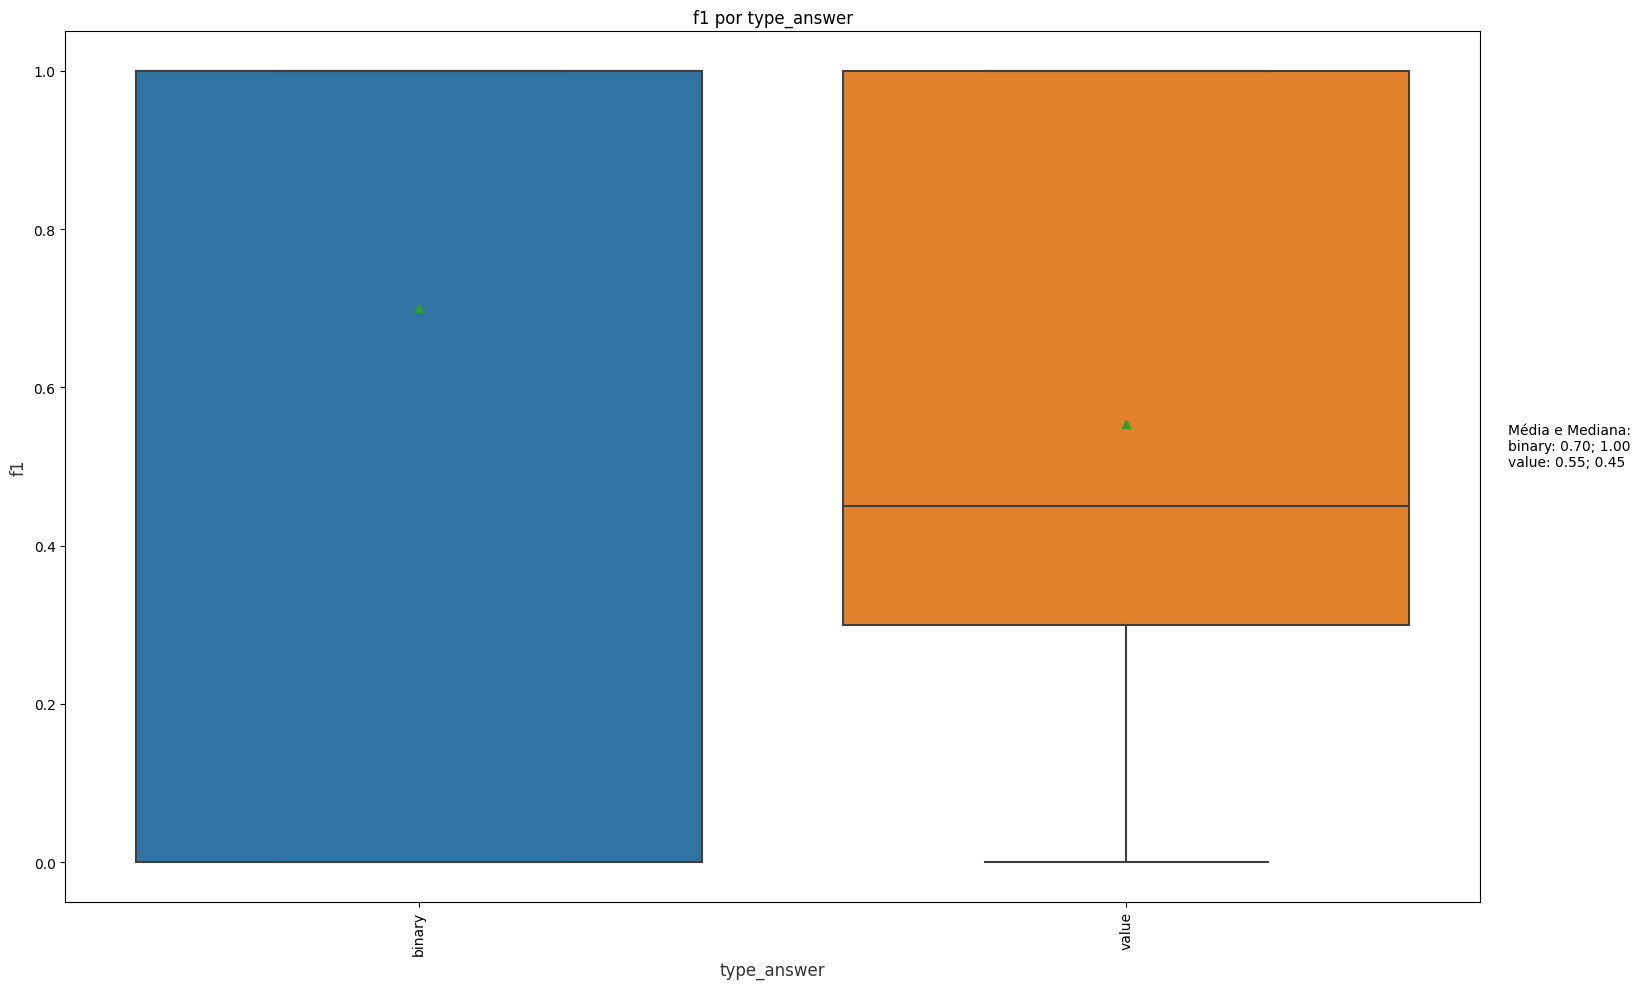

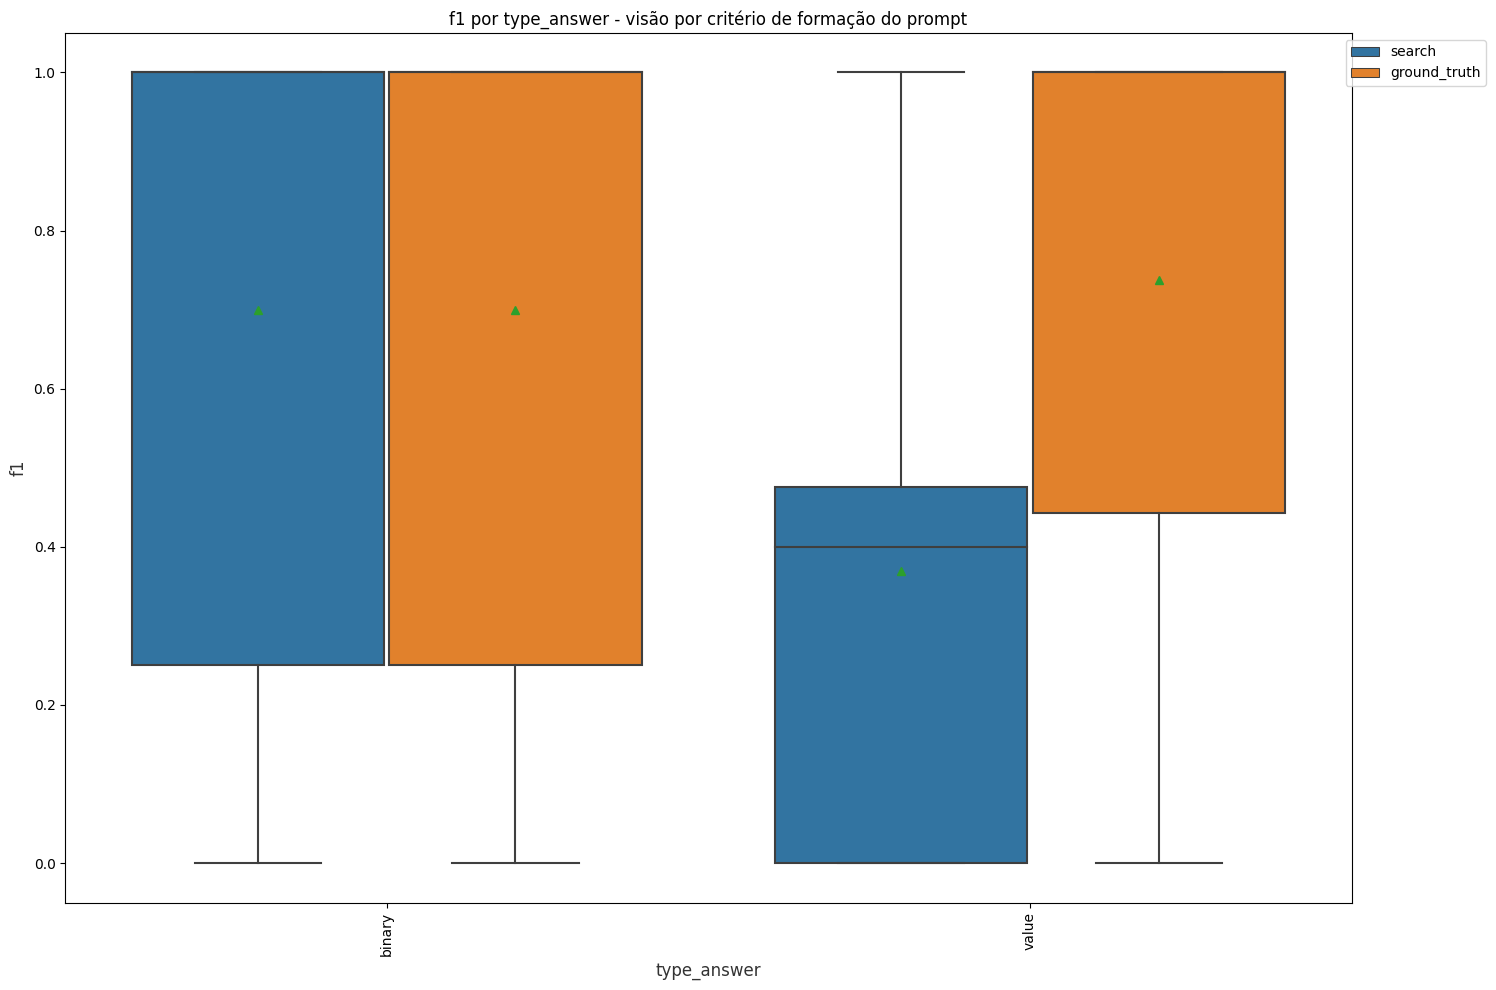

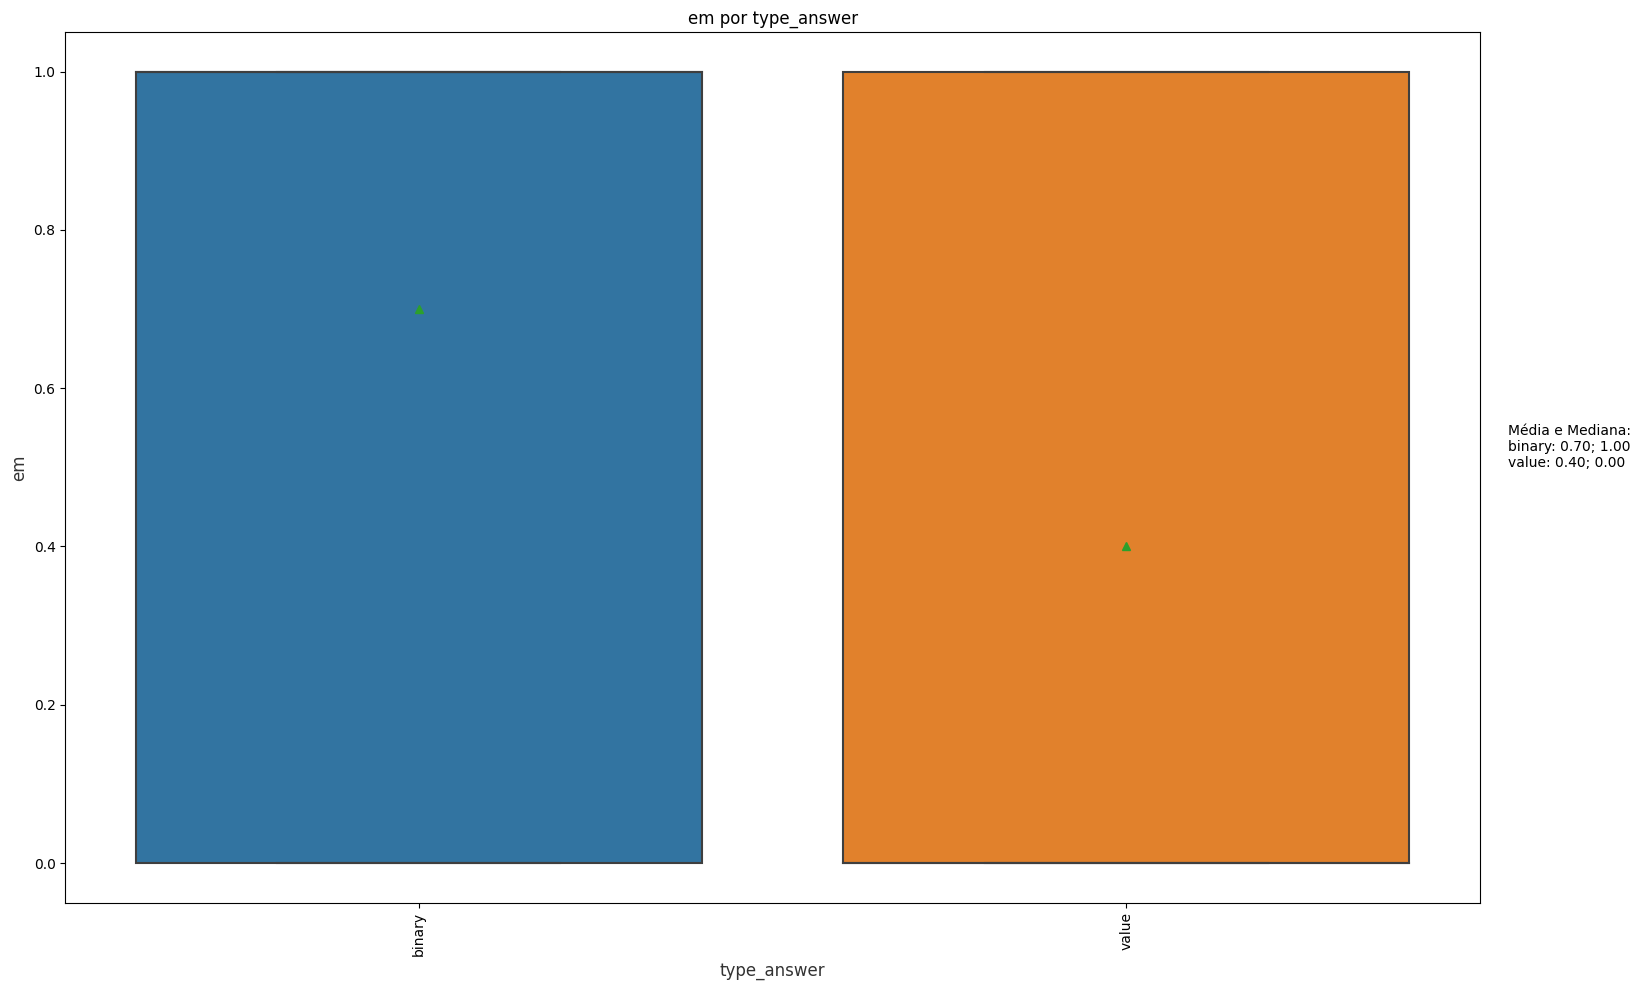

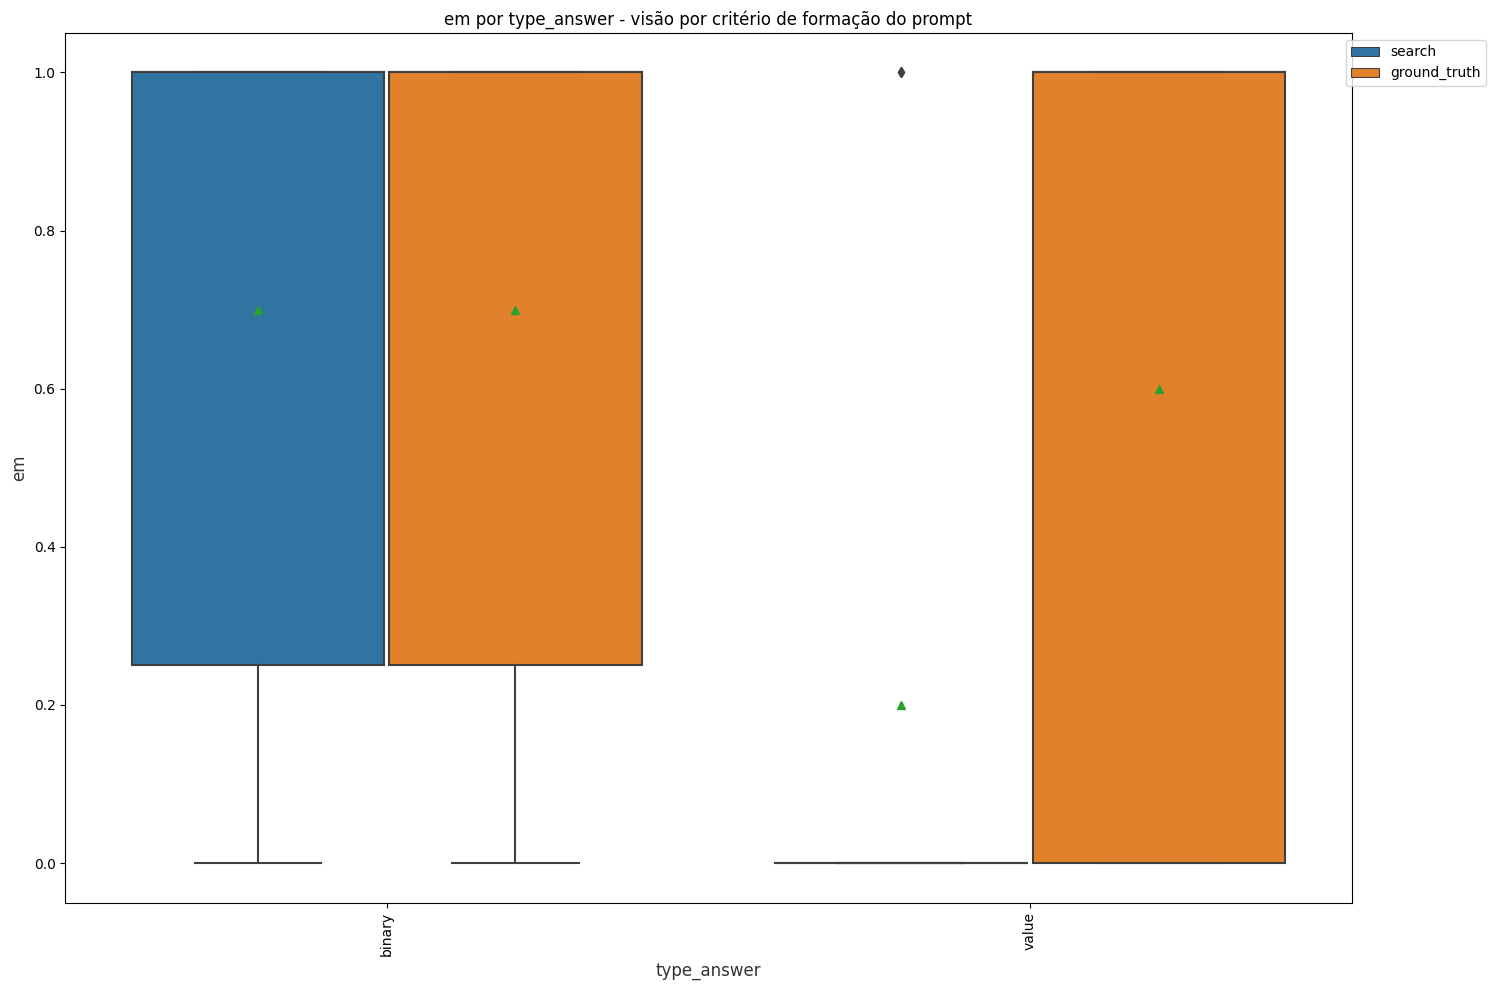

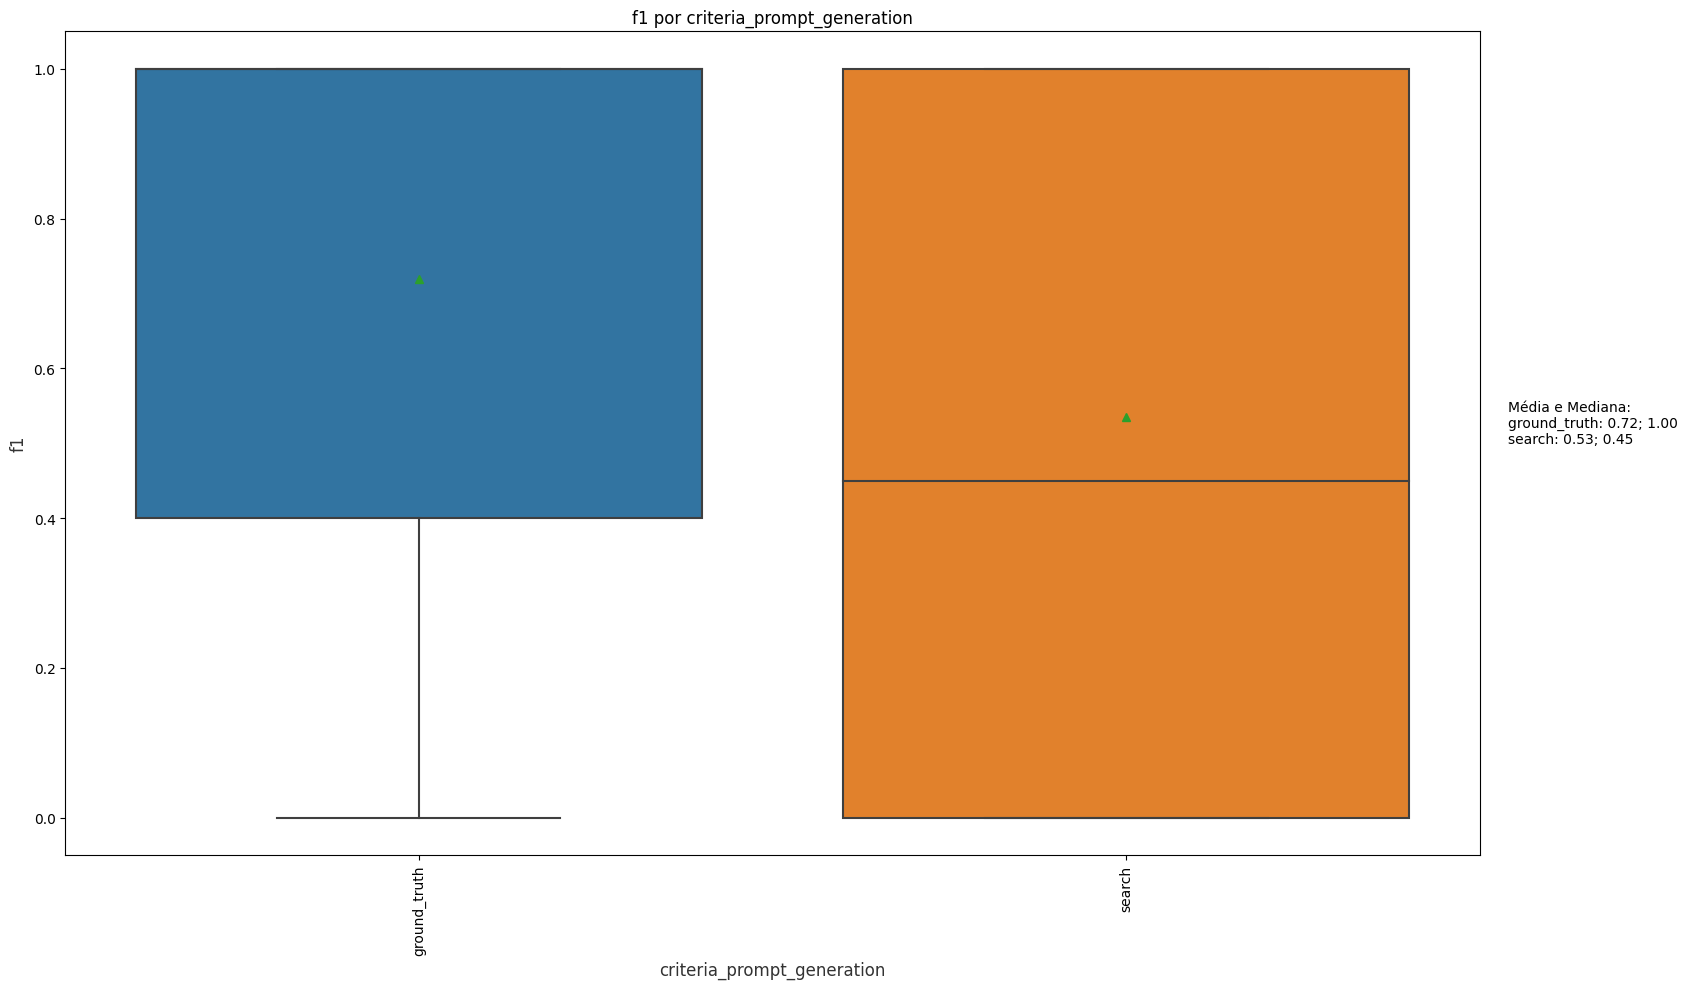

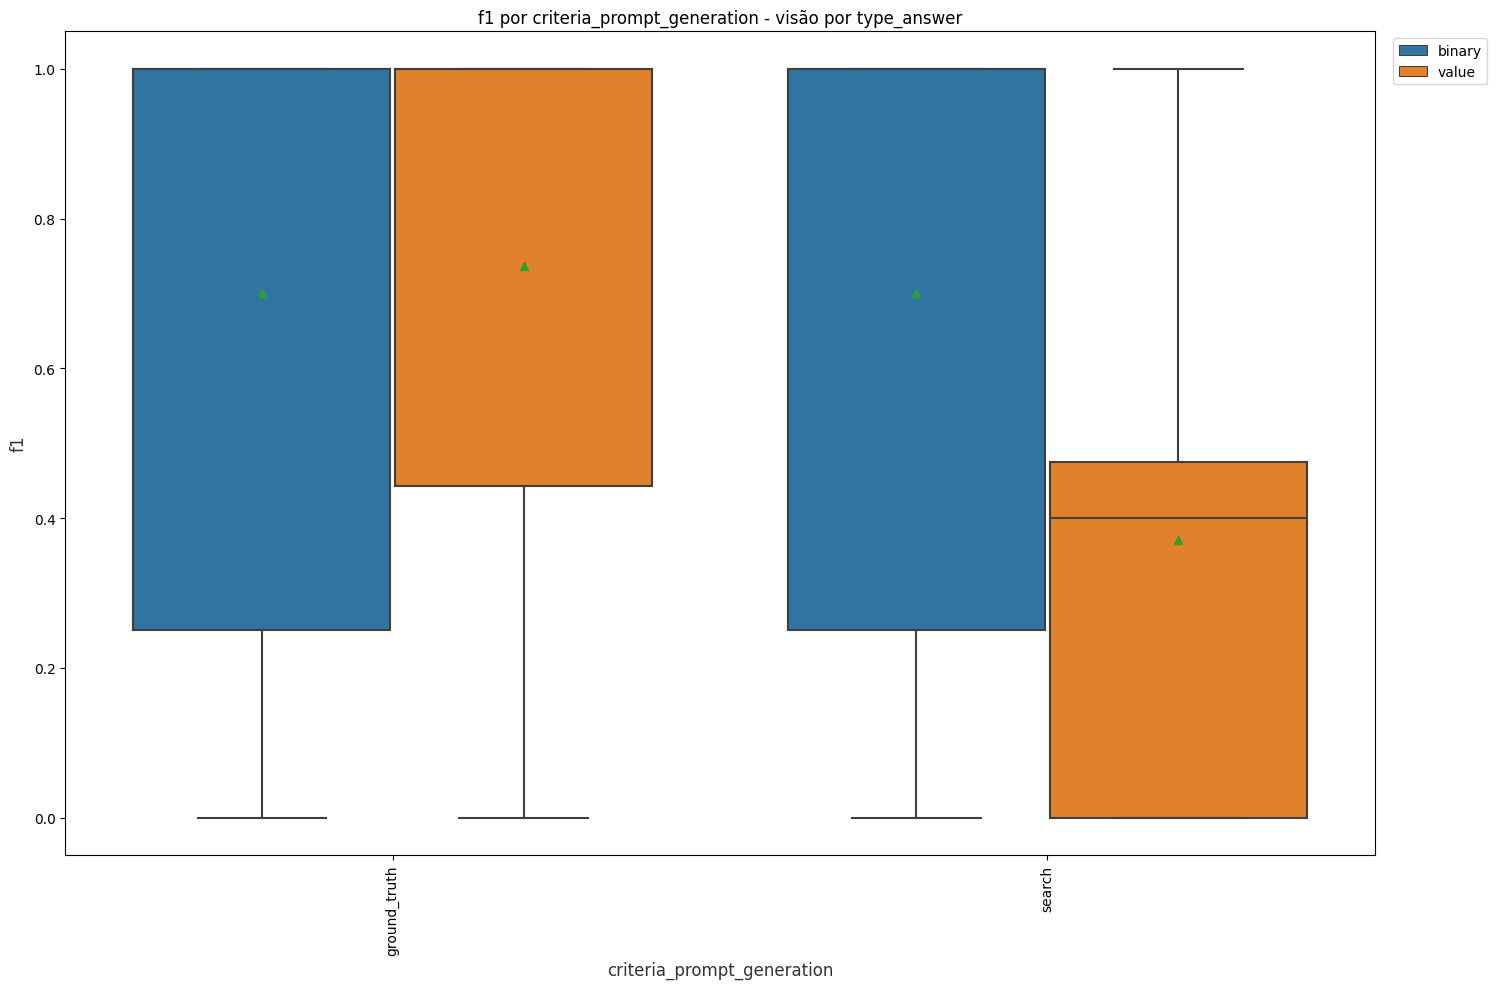

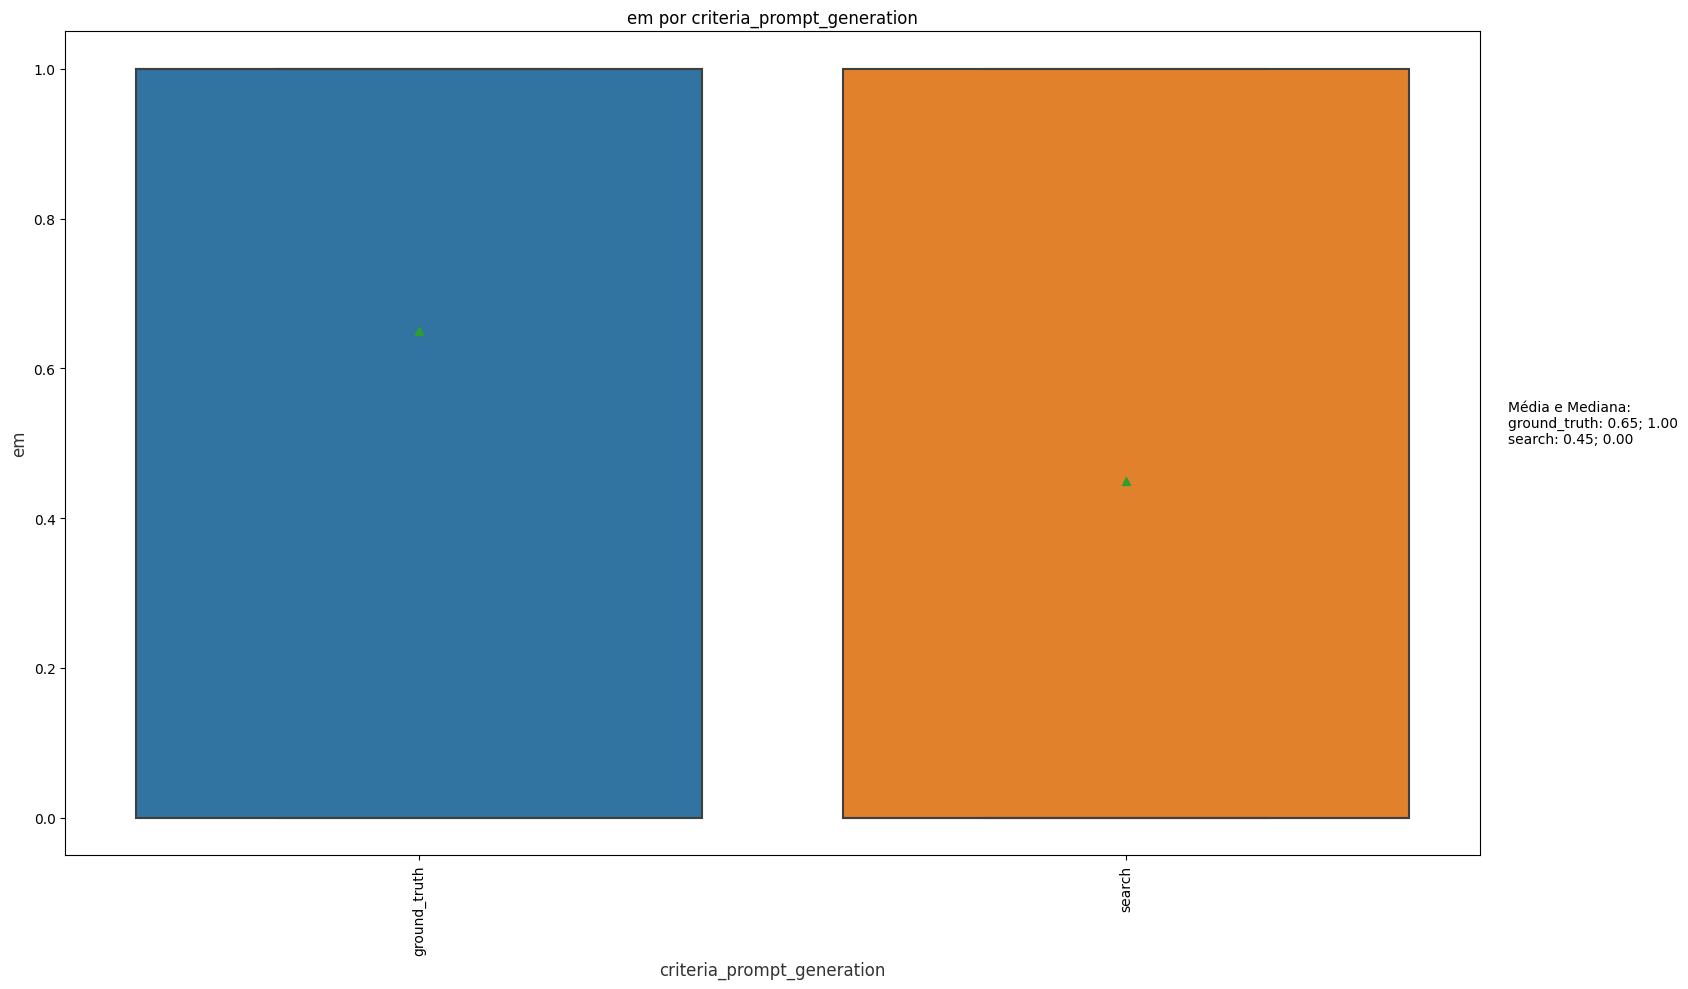

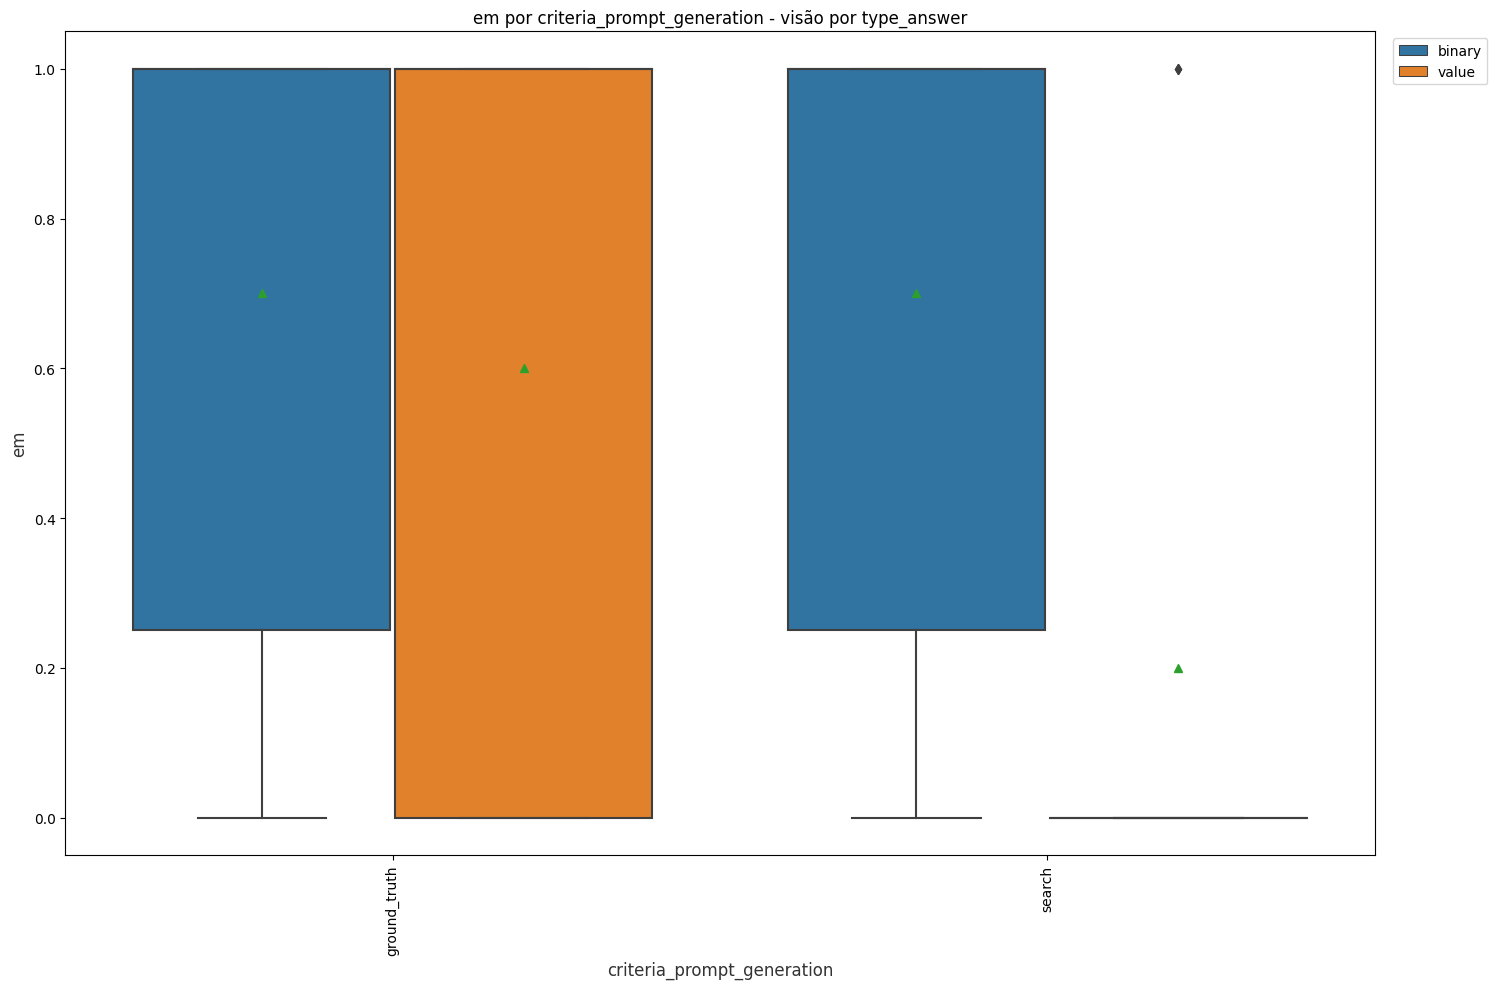

In [ ]:
for contexto in lista_nome_categoria: 
    for metrica in lista_nome_metrica:
        
        # criar lista com valores únicos da coluna a ser ordenada
        # valores_unicos = sorted(df[contexto].unique())
        
        valores_unicos = sorted(df[contexto].dropna().unique())


        f, ax = plt.subplots(1, 1, figsize=(15,10))
        sns.boxplot(x=contexto, y=metrica, data=df, showmeans=True, ax=ax, order=valores_unicos)
        ax.set_xlabel(contexto,size = 12,alpha=0.8)
        ax.set_ylabel(metrica,size = 12,alpha=0.8)
        ax.set_title(f'{metrica} por {contexto}')
        plt.xticks(rotation=90)
        plt.tight_layout()

        # Média e Mediana
        media = df.groupby(contexto)[metrica].mean()
        mediana = df.groupby(contexto)[metrica].median()
        mm_list = [f"{i}: {j:.2f}; {k:.2f}" for i,j,k in zip(media.index, media, mediana)]
        mm_str = "\n".join(mm_list)
        ax.text(1.02, 0.5, f"Média e Mediana:\n{mm_str}", transform=ax.transAxes)

        if contexto != 'type_answer':
            
            f, ax = plt.subplots(1, 1, figsize=(15,10))
            sns.boxplot(x=contexto, y=metrica, hue='type_answer' , data=df, showmeans=True, ax=ax, order=valores_unicos)
            f.subplots_adjust(top=0.5)


            ax.set_xlabel(contexto,size = 12,alpha=0.8)
            ax.set_ylabel(metrica,size = 12,alpha=0.8)
            ax.set_title(f'{metrica} por {contexto} - visão por type_answer')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper center', ncol=1)
            plt.xticks(rotation=90)
            plt.tight_layout()

        if contexto != 'criteria_prompt_generation':
            
            f, ax = plt.subplots(1, 1, figsize=(15,10))
            sns.boxplot(x=contexto, y=metrica, hue='criteria_prompt_generation' , data=df, showmeans=True, ax=ax, order=valores_unicos)
            f.subplots_adjust(top=0.5)


            ax.set_xlabel(contexto,size = 12,alpha=0.8)
            ax.set_ylabel(metrica,size = 12,alpha=0.8)
            ax.set_title(f'{metrica} por {contexto} - visão por critério de formação do prompt')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper center', ncol=1)
            plt.xticks(rotation=90)
            plt.tight_layout()


In [200]:
df

,prompt,answer,responses,results,completions,asked_twice,new_prompt,f1,em,answer_llm,type_answer,criteria_prompt_generation
0,Follow examples bellow and generate value for ...,no,[ no],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0000000,1,no,binary,search
1,Follow examples bellow and generate value for ...,yes,[],\n\nDocument 1 indicates that George Metcalfe ...,[\n\nDocument 1 indicates that George Metcalfe...,False,NaN,0.0000000,0,no,binary,search
2,Follow examples bellow and generate value for ...,yes,[],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",False,NaN,1.0000000,1,yes,binary,search
3,Follow examples bellow and generate value for ...,no,[\n\nUnknown],There is no mention of Type IXD2 submarines i...,[ There is no mention of Type IXD2 submarines ...,True,Follow examples bellow and generate value for ...,0.0000000,0,unknown,binary,search
4,Follow examples bellow and generate value for ...,no,[ no],Document 1 mentions that Arthur Archibald Den...,[ Document 1 mentions that Arthur Archibald De...,True,Follow examples bellow and generate value for ...,1.0000000,1,no,binary,search
5,Follow examples bellow and generate value for ...,no,[ no],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0000000,1,no,binary,search
6,Follow examples bellow and generate value for ...,yes,[ Yes],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0000000,1,yes,binary,search
7,Follow examples bellow and generate value for ...,yes,[\n\nYes],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0000000,1,yes,binary,search
8,Follow examples bellow and generate value for ...,yes,[\n\nNo.],There is no mention in any of the documents o...,[ There is no mention in any of the documents ...,True,Follow examples bellow and generate value for ...,0.0000000,0,no,binary,search
9,Follow examples bellow and generate value for ...,no,[ no],"Based on the information in the documents, it...","[ Based on the information in the documents, i...",True,Follow examples bellow and generate value for ...,1.0000000,1,no,binary,search
